In [39]:
#------# Import libraries and datasets #------#

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import datasets as dts
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import gc
import random
import spacy
%matplotlib inline

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler


from transformers import BertModel,AutoModel
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score, f1_score

In [40]:
dataset = dts.load_dataset('lex_glue','unfair_tos')

Found cached dataset lex_glue (/home/anas/.cache/huggingface/datasets/lex_glue/unfair_tos/1.0.0/8a66420941bf6e77a7ddd4da4d3bfb7ba88ef48c1d55302a568ac650a095ca3a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
train_dataset = pd.DataFrame.from_dict(dataset["train"])
val_dataset = pd.DataFrame.from_dict(dataset["validation"])
test_dataset = pd.DataFrame.from_dict(dataset["test"])

stop_words = list(stopwords.words('english'))

In [42]:
definitions = {"Limitation of liability": "this clause stipulates that the duty to pay damages is limited or excluded, for certain kind of losses, under certain conditions. "
               , "Unilateral termination": "this clause gives provider the right to suspend and/or terminate the service and/or the contract, and sometimes details the circumstances under which the provider claims to have a right to do so."
               , "Unilateral change": "this clause specifies the conditions under which the service provider could amend and modify the terms of service and/or the service itself."
               , "Content removal": "this clause gives the provider a right to modify/delete user’s content, including in-app purchases, and sometimes specifies the conditions under which the service provider may do so."
               , "Contract by using": "this clause stipulates that the consumer is bound by the terms of use of a specific service, simply by using the service, without even being required to mark that he or she has read and accepted them."
               , "Choice of law": "this clause specifies what law will govern the contract, meaning also what law will be applied in potential adjudication of a dispute arising under the contract."
               , "Jurisdiction": "this selection clause requires or allows the parties to resolve their disputes through an arbitration process, before the case could go to court."
               , "Arbitration": "this forum selection clause requires or allows the parties to resolve their disputes through an arbitration process, before the case could go to court however, such a clause may or may not specify that arbitration should occur within a specific jurisdiction. "}
label_to_def = {
    0 : "Limitation of liability",
    1 : "Unilateral termination",
    2 : "Unilateral change",
    3 : "Content removal",
    4 : "Contract by using",
    5 : "Choice of law",
    6 : "Jurisdiction",
    7 : "Arbitration"
}

entail_con = ["entails"]

In [43]:
def convert_to_entailment(dataset,defs,lab2def,ent_con,remove_unseen):
    new_dataset = {"text":[],"labels":[],"str_labels":[]}
    num_text = len(dataset["text"])
    nlp = spacy.load("en_core_web_sm")
    max_len = 0
    
    iteri = 0
    print ("garmi garmi : ",num_text)
    for i in range(0,num_text):
        if remove_unseen :
            if len(dataset["labels"][i]) > 0:
                iteri +=1
                print (iteri,"/",num_text)
                old_string = dataset["text"][i]
                random_number = random.randint(0, len(ent_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + ent_con[random_number] + " " + definitions[label_to_def[j]]
                    new_dataset["text"].append(new_string)
                    new_dataset["str_labels"].append(str(dataset["labels"][i]))
                    if j in dataset["labels"][i]:
                        new_dataset["labels"].append([0,1])
                    else:
                        new_dataset["labels"].append([1,0])

                    doc2 = nlp(new_string)
                    if len(doc2) > max_len :
                        max_len = len(doc2)
        else:
            iteri +=1
            print (iteri,"/",num_text)
            print (i,"/",num_text)
            old_string = dataset["text"][i]
            random_number = random.randint(0, len(ent_con)) - 1
            doc = nlp(old_string)
            old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
            for j in range(0,8):
                new_string = old_string + " " + ent_con[random_number] + " " + definitions[label_to_def[j]]
                new_dataset["text"].append(new_string)
                new_dataset["str_labels"].append(str(dataset["labels"][i]))
                if j in dataset["labels"][i]:
                    new_dataset["labels"].append([0,1])
                else:
                    new_dataset["labels"].append([1,0])

                doc2 = nlp(new_string)
                if len(doc2) > max_len :
                    max_len = len(doc2)
            
    
    return new_dataset,max_len

train_dataset_ent, train_max = convert_to_entailment(train_dataset,definitions,label_to_def,entail_con,True)
val_dataset_ent, val_max = convert_to_entailment(val_dataset,definitions,label_to_def,entail_con,False)
test_dataset_ent, test_max = convert_to_entailment(test_dataset,definitions,label_to_def,entail_con,False)

print (train_max, val_max, test_max)

garmi garmi :  5532
1 / 5532
2 / 5532
3 / 5532
4 / 5532
5 / 5532
6 / 5532
7 / 5532
8 / 5532
9 / 5532
10 / 5532
11 / 5532
12 / 5532
13 / 5532
14 / 5532
15 / 5532
16 / 5532
17 / 5532
18 / 5532
19 / 5532
20 / 5532
21 / 5532
22 / 5532
23 / 5532
24 / 5532
25 / 5532
26 / 5532
27 / 5532
28 / 5532
29 / 5532
30 / 5532
31 / 5532
32 / 5532
33 / 5532
34 / 5532
35 / 5532
36 / 5532
37 / 5532
38 / 5532
39 / 5532
40 / 5532
41 / 5532
42 / 5532
43 / 5532
44 / 5532
45 / 5532
46 / 5532
47 / 5532
48 / 5532
49 / 5532
50 / 5532
51 / 5532
52 / 5532
53 / 5532
54 / 5532
55 / 5532
56 / 5532
57 / 5532
58 / 5532
59 / 5532
60 / 5532
61 / 5532
62 / 5532
63 / 5532
64 / 5532
65 / 5532
66 / 5532
67 / 5532
68 / 5532
69 / 5532
70 / 5532
71 / 5532
72 / 5532
73 / 5532
74 / 5532
75 / 5532
76 / 5532
77 / 5532
78 / 5532
79 / 5532
80 / 5532
81 / 5532
82 / 5532
83 / 5532
84 / 5532
85 / 5532
86 / 5532
87 / 5532
88 / 5532
89 / 5532
90 / 5532
91 / 5532
92 / 5532
93 / 5532
94 / 5532
95 / 5532
96 / 5532
97 / 5532
98 / 5532
99 / 5532

72 / 2275
71 / 2275
73 / 2275
72 / 2275
74 / 2275
73 / 2275
75 / 2275
74 / 2275
76 / 2275
75 / 2275
77 / 2275
76 / 2275
78 / 2275
77 / 2275
79 / 2275
78 / 2275
80 / 2275
79 / 2275
81 / 2275
80 / 2275
82 / 2275
81 / 2275
83 / 2275
82 / 2275
84 / 2275
83 / 2275
85 / 2275
84 / 2275
86 / 2275
85 / 2275
87 / 2275
86 / 2275
88 / 2275
87 / 2275
89 / 2275
88 / 2275
90 / 2275
89 / 2275
91 / 2275
90 / 2275
92 / 2275
91 / 2275
93 / 2275
92 / 2275
94 / 2275
93 / 2275
95 / 2275
94 / 2275
96 / 2275
95 / 2275
97 / 2275
96 / 2275
98 / 2275
97 / 2275
99 / 2275
98 / 2275
100 / 2275
99 / 2275
101 / 2275
100 / 2275
102 / 2275
101 / 2275
103 / 2275
102 / 2275
104 / 2275
103 / 2275
105 / 2275
104 / 2275
106 / 2275
105 / 2275
107 / 2275
106 / 2275
108 / 2275
107 / 2275
109 / 2275
108 / 2275
110 / 2275
109 / 2275
111 / 2275
110 / 2275
112 / 2275
111 / 2275
113 / 2275
112 / 2275
114 / 2275
113 / 2275
115 / 2275
114 / 2275
116 / 2275
115 / 2275
117 / 2275
116 / 2275
118 / 2275
117 / 2275
119 / 2275
118 / 2275
1

450 / 2275
449 / 2275
451 / 2275
450 / 2275
452 / 2275
451 / 2275
453 / 2275
452 / 2275
454 / 2275
453 / 2275
455 / 2275
454 / 2275
456 / 2275
455 / 2275
457 / 2275
456 / 2275
458 / 2275
457 / 2275
459 / 2275
458 / 2275
460 / 2275
459 / 2275
461 / 2275
460 / 2275
462 / 2275
461 / 2275
463 / 2275
462 / 2275
464 / 2275
463 / 2275
465 / 2275
464 / 2275
466 / 2275
465 / 2275
467 / 2275
466 / 2275
468 / 2275
467 / 2275
469 / 2275
468 / 2275
470 / 2275
469 / 2275
471 / 2275
470 / 2275
472 / 2275
471 / 2275
473 / 2275
472 / 2275
474 / 2275
473 / 2275
475 / 2275
474 / 2275
476 / 2275
475 / 2275
477 / 2275
476 / 2275
478 / 2275
477 / 2275
479 / 2275
478 / 2275
480 / 2275
479 / 2275
481 / 2275
480 / 2275
482 / 2275
481 / 2275
483 / 2275
482 / 2275
484 / 2275
483 / 2275
485 / 2275
484 / 2275
486 / 2275
485 / 2275
487 / 2275
486 / 2275
488 / 2275
487 / 2275
489 / 2275
488 / 2275
490 / 2275
489 / 2275
491 / 2275
490 / 2275
492 / 2275
491 / 2275
493 / 2275
492 / 2275
494 / 2275
493 / 2275
495 / 2275

826 / 2275
825 / 2275
827 / 2275
826 / 2275
828 / 2275
827 / 2275
829 / 2275
828 / 2275
830 / 2275
829 / 2275
831 / 2275
830 / 2275
832 / 2275
831 / 2275
833 / 2275
832 / 2275
834 / 2275
833 / 2275
835 / 2275
834 / 2275
836 / 2275
835 / 2275
837 / 2275
836 / 2275
838 / 2275
837 / 2275
839 / 2275
838 / 2275
840 / 2275
839 / 2275
841 / 2275
840 / 2275
842 / 2275
841 / 2275
843 / 2275
842 / 2275
844 / 2275
843 / 2275
845 / 2275
844 / 2275
846 / 2275
845 / 2275
847 / 2275
846 / 2275
848 / 2275
847 / 2275
849 / 2275
848 / 2275
850 / 2275
849 / 2275
851 / 2275
850 / 2275
852 / 2275
851 / 2275
853 / 2275
852 / 2275
854 / 2275
853 / 2275
855 / 2275
854 / 2275
856 / 2275
855 / 2275
857 / 2275
856 / 2275
858 / 2275
857 / 2275
859 / 2275
858 / 2275
860 / 2275
859 / 2275
861 / 2275
860 / 2275
862 / 2275
861 / 2275
863 / 2275
862 / 2275
864 / 2275
863 / 2275
865 / 2275
864 / 2275
866 / 2275
865 / 2275
867 / 2275
866 / 2275
868 / 2275
867 / 2275
869 / 2275
868 / 2275
870 / 2275
869 / 2275
871 / 2275

1183 / 2275
1182 / 2275
1184 / 2275
1183 / 2275
1185 / 2275
1184 / 2275
1186 / 2275
1185 / 2275
1187 / 2275
1186 / 2275
1188 / 2275
1187 / 2275
1189 / 2275
1188 / 2275
1190 / 2275
1189 / 2275
1191 / 2275
1190 / 2275
1192 / 2275
1191 / 2275
1193 / 2275
1192 / 2275
1194 / 2275
1193 / 2275
1195 / 2275
1194 / 2275
1196 / 2275
1195 / 2275
1197 / 2275
1196 / 2275
1198 / 2275
1197 / 2275
1199 / 2275
1198 / 2275
1200 / 2275
1199 / 2275
1201 / 2275
1200 / 2275
1202 / 2275
1201 / 2275
1203 / 2275
1202 / 2275
1204 / 2275
1203 / 2275
1205 / 2275
1204 / 2275
1206 / 2275
1205 / 2275
1207 / 2275
1206 / 2275
1208 / 2275
1207 / 2275
1209 / 2275
1208 / 2275
1210 / 2275
1209 / 2275
1211 / 2275
1210 / 2275
1212 / 2275
1211 / 2275
1213 / 2275
1212 / 2275
1214 / 2275
1213 / 2275
1215 / 2275
1214 / 2275
1216 / 2275
1215 / 2275
1217 / 2275
1216 / 2275
1218 / 2275
1217 / 2275
1219 / 2275
1218 / 2275
1220 / 2275
1219 / 2275
1221 / 2275
1220 / 2275
1222 / 2275
1221 / 2275
1223 / 2275
1222 / 2275
1224 / 2275
1223

1528 / 2275
1527 / 2275
1529 / 2275
1528 / 2275
1530 / 2275
1529 / 2275
1531 / 2275
1530 / 2275
1532 / 2275
1531 / 2275
1533 / 2275
1532 / 2275
1534 / 2275
1533 / 2275
1535 / 2275
1534 / 2275
1536 / 2275
1535 / 2275
1537 / 2275
1536 / 2275
1538 / 2275
1537 / 2275
1539 / 2275
1538 / 2275
1540 / 2275
1539 / 2275
1541 / 2275
1540 / 2275
1542 / 2275
1541 / 2275
1543 / 2275
1542 / 2275
1544 / 2275
1543 / 2275
1545 / 2275
1544 / 2275
1546 / 2275
1545 / 2275
1547 / 2275
1546 / 2275
1548 / 2275
1547 / 2275
1549 / 2275
1548 / 2275
1550 / 2275
1549 / 2275
1551 / 2275
1550 / 2275
1552 / 2275
1551 / 2275
1553 / 2275
1552 / 2275
1554 / 2275
1553 / 2275
1555 / 2275
1554 / 2275
1556 / 2275
1555 / 2275
1557 / 2275
1556 / 2275
1558 / 2275
1557 / 2275
1559 / 2275
1558 / 2275
1560 / 2275
1559 / 2275
1561 / 2275
1560 / 2275
1562 / 2275
1561 / 2275
1563 / 2275
1562 / 2275
1564 / 2275
1563 / 2275
1565 / 2275
1564 / 2275
1566 / 2275
1565 / 2275
1567 / 2275
1566 / 2275
1568 / 2275
1567 / 2275
1569 / 2275
1568

1872 / 2275
1871 / 2275
1873 / 2275
1872 / 2275
1874 / 2275
1873 / 2275
1875 / 2275
1874 / 2275
1876 / 2275
1875 / 2275
1877 / 2275
1876 / 2275
1878 / 2275
1877 / 2275
1879 / 2275
1878 / 2275
1880 / 2275
1879 / 2275
1881 / 2275
1880 / 2275
1882 / 2275
1881 / 2275
1883 / 2275
1882 / 2275
1884 / 2275
1883 / 2275
1885 / 2275
1884 / 2275
1886 / 2275
1885 / 2275
1887 / 2275
1886 / 2275
1888 / 2275
1887 / 2275
1889 / 2275
1888 / 2275
1890 / 2275
1889 / 2275
1891 / 2275
1890 / 2275
1892 / 2275
1891 / 2275
1893 / 2275
1892 / 2275
1894 / 2275
1893 / 2275
1895 / 2275
1894 / 2275
1896 / 2275
1895 / 2275
1897 / 2275
1896 / 2275
1898 / 2275
1897 / 2275
1899 / 2275
1898 / 2275
1900 / 2275
1899 / 2275
1901 / 2275
1900 / 2275
1902 / 2275
1901 / 2275
1903 / 2275
1902 / 2275
1904 / 2275
1903 / 2275
1905 / 2275
1904 / 2275
1906 / 2275
1905 / 2275
1907 / 2275
1906 / 2275
1908 / 2275
1907 / 2275
1909 / 2275
1908 / 2275
1910 / 2275
1909 / 2275
1911 / 2275
1910 / 2275
1912 / 2275
1911 / 2275
1913 / 2275
1912

2214 / 2275
2213 / 2275
2215 / 2275
2214 / 2275
2216 / 2275
2215 / 2275
2217 / 2275
2216 / 2275
2218 / 2275
2217 / 2275
2219 / 2275
2218 / 2275
2220 / 2275
2219 / 2275
2221 / 2275
2220 / 2275
2222 / 2275
2221 / 2275
2223 / 2275
2222 / 2275
2224 / 2275
2223 / 2275
2225 / 2275
2224 / 2275
2226 / 2275
2225 / 2275
2227 / 2275
2226 / 2275
2228 / 2275
2227 / 2275
2229 / 2275
2228 / 2275
2230 / 2275
2229 / 2275
2231 / 2275
2230 / 2275
2232 / 2275
2231 / 2275
2233 / 2275
2232 / 2275
2234 / 2275
2233 / 2275
2235 / 2275
2234 / 2275
2236 / 2275
2235 / 2275
2237 / 2275
2236 / 2275
2238 / 2275
2237 / 2275
2239 / 2275
2238 / 2275
2240 / 2275
2239 / 2275
2241 / 2275
2240 / 2275
2242 / 2275
2241 / 2275
2243 / 2275
2242 / 2275
2244 / 2275
2243 / 2275
2245 / 2275
2244 / 2275
2246 / 2275
2245 / 2275
2247 / 2275
2246 / 2275
2248 / 2275
2247 / 2275
2249 / 2275
2248 / 2275
2250 / 2275
2249 / 2275
2251 / 2275
2250 / 2275
2252 / 2275
2251 / 2275
2253 / 2275
2252 / 2275
2254 / 2275
2253 / 2275
2255 / 2275
2254

315 / 1607
314 / 1607
316 / 1607
315 / 1607
317 / 1607
316 / 1607
318 / 1607
317 / 1607
319 / 1607
318 / 1607
320 / 1607
319 / 1607
321 / 1607
320 / 1607
322 / 1607
321 / 1607
323 / 1607
322 / 1607
324 / 1607
323 / 1607
325 / 1607
324 / 1607
326 / 1607
325 / 1607
327 / 1607
326 / 1607
328 / 1607
327 / 1607
329 / 1607
328 / 1607
330 / 1607
329 / 1607
331 / 1607
330 / 1607
332 / 1607
331 / 1607
333 / 1607
332 / 1607
334 / 1607
333 / 1607
335 / 1607
334 / 1607
336 / 1607
335 / 1607
337 / 1607
336 / 1607
338 / 1607
337 / 1607
339 / 1607
338 / 1607
340 / 1607
339 / 1607
341 / 1607
340 / 1607
342 / 1607
341 / 1607
343 / 1607
342 / 1607
344 / 1607
343 / 1607
345 / 1607
344 / 1607
346 / 1607
345 / 1607
347 / 1607
346 / 1607
348 / 1607
347 / 1607
349 / 1607
348 / 1607
350 / 1607
349 / 1607
351 / 1607
350 / 1607
352 / 1607
351 / 1607
353 / 1607
352 / 1607
354 / 1607
353 / 1607
355 / 1607
354 / 1607
356 / 1607
355 / 1607
357 / 1607
356 / 1607
358 / 1607
357 / 1607
359 / 1607
358 / 1607
360 / 1607

689 / 1607
688 / 1607
690 / 1607
689 / 1607
691 / 1607
690 / 1607
692 / 1607
691 / 1607
693 / 1607
692 / 1607
694 / 1607
693 / 1607
695 / 1607
694 / 1607
696 / 1607
695 / 1607
697 / 1607
696 / 1607
698 / 1607
697 / 1607
699 / 1607
698 / 1607
700 / 1607
699 / 1607
701 / 1607
700 / 1607
702 / 1607
701 / 1607
703 / 1607
702 / 1607
704 / 1607
703 / 1607
705 / 1607
704 / 1607
706 / 1607
705 / 1607
707 / 1607
706 / 1607
708 / 1607
707 / 1607
709 / 1607
708 / 1607
710 / 1607
709 / 1607
711 / 1607
710 / 1607
712 / 1607
711 / 1607
713 / 1607
712 / 1607
714 / 1607
713 / 1607
715 / 1607
714 / 1607
716 / 1607
715 / 1607
717 / 1607
716 / 1607
718 / 1607
717 / 1607
719 / 1607
718 / 1607
720 / 1607
719 / 1607
721 / 1607
720 / 1607
722 / 1607
721 / 1607
723 / 1607
722 / 1607
724 / 1607
723 / 1607
725 / 1607
724 / 1607
726 / 1607
725 / 1607
727 / 1607
726 / 1607
728 / 1607
727 / 1607
729 / 1607
728 / 1607
730 / 1607
729 / 1607
731 / 1607
730 / 1607
732 / 1607
731 / 1607
733 / 1607
732 / 1607
734 / 1607

1060 / 1607
1059 / 1607
1061 / 1607
1060 / 1607
1062 / 1607
1061 / 1607
1063 / 1607
1062 / 1607
1064 / 1607
1063 / 1607
1065 / 1607
1064 / 1607
1066 / 1607
1065 / 1607
1067 / 1607
1066 / 1607
1068 / 1607
1067 / 1607
1069 / 1607
1068 / 1607
1070 / 1607
1069 / 1607
1071 / 1607
1070 / 1607
1072 / 1607
1071 / 1607
1073 / 1607
1072 / 1607
1074 / 1607
1073 / 1607
1075 / 1607
1074 / 1607
1076 / 1607
1075 / 1607
1077 / 1607
1076 / 1607
1078 / 1607
1077 / 1607
1079 / 1607
1078 / 1607
1080 / 1607
1079 / 1607
1081 / 1607
1080 / 1607
1082 / 1607
1081 / 1607
1083 / 1607
1082 / 1607
1084 / 1607
1083 / 1607
1085 / 1607
1084 / 1607
1086 / 1607
1085 / 1607
1087 / 1607
1086 / 1607
1088 / 1607
1087 / 1607
1089 / 1607
1088 / 1607
1090 / 1607
1089 / 1607
1091 / 1607
1090 / 1607
1092 / 1607
1091 / 1607
1093 / 1607
1092 / 1607
1094 / 1607
1093 / 1607
1095 / 1607
1094 / 1607
1096 / 1607
1095 / 1607
1097 / 1607
1096 / 1607
1098 / 1607
1097 / 1607
1099 / 1607
1098 / 1607
1100 / 1607
1099 / 1607
1101 / 1607
1100

1403 / 1607
1402 / 1607
1404 / 1607
1403 / 1607
1405 / 1607
1404 / 1607
1406 / 1607
1405 / 1607
1407 / 1607
1406 / 1607
1408 / 1607
1407 / 1607
1409 / 1607
1408 / 1607
1410 / 1607
1409 / 1607
1411 / 1607
1410 / 1607
1412 / 1607
1411 / 1607
1413 / 1607
1412 / 1607
1414 / 1607
1413 / 1607
1415 / 1607
1414 / 1607
1416 / 1607
1415 / 1607
1417 / 1607
1416 / 1607
1418 / 1607
1417 / 1607
1419 / 1607
1418 / 1607
1420 / 1607
1419 / 1607
1421 / 1607
1420 / 1607
1422 / 1607
1421 / 1607
1423 / 1607
1422 / 1607
1424 / 1607
1423 / 1607
1425 / 1607
1424 / 1607
1426 / 1607
1425 / 1607
1427 / 1607
1426 / 1607
1428 / 1607
1427 / 1607
1429 / 1607
1428 / 1607
1430 / 1607
1429 / 1607
1431 / 1607
1430 / 1607
1432 / 1607
1431 / 1607
1433 / 1607
1432 / 1607
1434 / 1607
1433 / 1607
1435 / 1607
1434 / 1607
1436 / 1607
1435 / 1607
1437 / 1607
1436 / 1607
1438 / 1607
1437 / 1607
1439 / 1607
1438 / 1607
1440 / 1607
1439 / 1607
1441 / 1607
1440 / 1607
1442 / 1607
1441 / 1607
1443 / 1607
1442 / 1607
1444 / 1607
1443

In [44]:
class CustomDataset(Dataset):
    def __init__(self, dataset,num_classes,tokenizer):
        
        self.dataset = dataset
        self.texts = self.dataset["text"]
        self.labels = self.dataset["labels"]
        self.num_classes = num_classes
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
    
        multi_label = torch.tensor(label,dtype=torch.float)
        #multi_label = torch.zeros(self.num_classes, dtype=torch.float32)
        #multi_label[label] = 1
        
        return {'input_ids':input_ids, 'attention_mask':attention_mask, 'multi_label':multi_label}
    
def find_metrics(targets,prediction):
    final_pred = ((torch.sigmoid(prediction) >= 0.5) * 1.0) 
    np_tar = targets.cpu().detach().numpy()
    np_pred = final_pred.cpu().detach().numpy()
    
    avg_f1_mic = f1_score(np_tar.flatten(), np_pred.flatten(), average='micro',zero_division=0)
    avg_f1_mac = f1_score(np_tar, np_pred, average='macro',zero_division=1)
    avg_acc = accuracy_score(np_tar, np_pred)
    del np_tar
    del np_pred
    del final_pred
    return avg_f1_mic, avg_f1_mac, avg_acc

def list_it(curr):
    return [curr]

def delist_it(curr):
    new_list = []
    for i in curr:
        new_list.append(i[0][0])
    return new_list

def str2list(curr):
    if curr=="[]":
        return []
    else:
        return [int(x) for x in curr[1:-1].split(',')]

batch_size = 16
num_classes = 2
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_custom = CustomDataset(train_dataset_ent, num_classes,tokenizer)
train_dataloader = DataLoader(train_custom, batch_size=batch_size, shuffle=True)
valid_custom = CustomDataset(val_dataset_ent, num_classes,tokenizer)
val_dataloader = DataLoader(valid_custom, batch_size=batch_size, shuffle=True)

<AxesSubplot:ylabel='labels'>

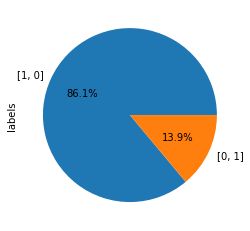

In [45]:
pd.DataFrame.from_dict(train_dataset_ent)["labels"].value_counts().plot.pie(autopct='%1.1f%%')

In [46]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
        #self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)
        #self.sig = torch.nn.GELU()
        
    def forward(self, input_ids, attention_mask):
        _ , pooled_output = self.bert(input_ids=input_ids, attention_mask =attention_mask,return_dict=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        #prediction = self.sig(logits)
        
        return logits

learning_rate = 3e-5
base_model = BERTClassifier(num_classes)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)
print (base_model)

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


def train(base_model,train_dataloader,optimizer,loss_function):
    # Training loop
    num_epochs = 20
    valid_interval = 20  # Perform validation and save model every 10 iterations
    iteration = 0
    max_f1 = 0
    stop_criterion = 2000000

    running_loss = []
    for epoch in range(num_epochs):
        base_model.train()  # Set the model to training mode
        for curr_batch in train_dataloader:
            
            if iteration > stop_criterion:
                break
            
            input_ids = curr_batch['input_ids'].to(device)
            attention_mask = curr_batch['attention_mask'].to(device)
            targets = curr_batch['multi_label'].to(device)



            outputs = base_model(input_ids,attention_mask)
            loss = loss_function(outputs.to(device), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print (iteration)
            running_loss.append(loss.item())
            if len(running_loss) > 20:
                running_loss.pop(0)
            print (f"Epoch : {epoch} ,Iteration : {iteration}, training loss: {loss:.4f} , running loss:{sum(running_loss)/len(running_loss)}",find_metrics(targets,outputs))
            
            # freeing up excess memory
            del loss, outputs
            gc.collect()
            torch.cuda.empty_cache()
            
            
            # Validation and model saving
            if iteration % valid_interval == 0:
                base_model.eval()  # Set the model to evaluation mode

                with torch.no_grad():
                    total_loss = []
                    f1_micro = []
                    f1_macro = []
                    f1_avg = []
                    for val_batch in val_dataloader:
                        val_input_ids = val_batch['input_ids'].to(device)
                        val_attention_mask = val_batch['attention_mask'].to(device)
                        val_targets = val_batch['multi_label'].to(device)


                        outputs = base_model(val_input_ids,val_attention_mask)
                        loss = loss_function(outputs.to(device), val_targets)
                        
                        total_loss.append(loss.item())
                        val_out = find_metrics(val_targets,outputs)
                        f1_micro.append(val_out[0])
                        f1_macro.append(val_out[1])
                        f1_avg.append(val_out[2])
                        
                        # emptying memory
                        del val_out, loss, outputs
                        gc.collect()
                        torch.cuda.empty_cache()
                        
                    avg_acc = sum(f1_avg)/len(f1_avg)
                    avg_f1mic = sum(f1_micro)/len(f1_micro)
                    avg_f1mac = sum(f1_macro)/len(f1_macro)
                    avg_loss = sum(total_loss)/len(total_loss)
                    
                    print (f"Validation loss : {sum(total_loss)/len(total_loss)} ", ' ,acc : ',avg_acc," ,f1-micro : ",avg_f1mic," ,f1-macro : ",avg_f1mac)
                    if avg_f1mac > max_f1 :
                        max_f1 = avg_f1mic
                        torch.save(base_model.state_dict(),f"model_trained_ent/model_{iteration}.pth")
                    
                    del total_loss, f1_micro, f1_macro, f1_avg

                base_model.train()  # Set the model back to training mode
            
            iteration += 1
    return base_model, train_dataloader, optimizer, loss_function

base_model, train_dataloader, optimizer, loss_function = train(base_model,train_dataloader,optimizer,loss_function)

Epoch : 0 ,Iteration : 0, training loss: 0.2581 , running loss:0.2580529451370239 (0.9375, 0.4838709677419355, 0.9375)
Validation loss : 0.17057962024253784   ,acc :  0.9863246924428822  ,f1-micro :  0.9863246924428822  ,f1-macro :  0.8958358339963775
Epoch : 0 ,Iteration : 1, training loss: 0.4787 , running loss:0.3683883249759674 (0.8125, 0.4482758620689655, 0.8125)
Epoch : 0 ,Iteration : 2, training loss: 0.9411 , running loss:0.5592900315920512 (0.5625, 0.36, 0.5625)
Epoch : 0 ,Iteration : 3, training loss: 0.2561 , running loss:0.48348887264728546 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 4, training loss: 0.2591 , running loss:0.43860278129577634 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 5, training loss: 0.3882 , running loss:0.4302089909712474 (0.875, 0.4666666666666667, 0.875)
Epoch : 0 ,Iteration : 6, training loss: 0.7704 , running loss:0.47880283423832487 (0.625, 0.38461538461538464, 0.625)
Epoch : 0 ,Iteration : 7, training loss: 0.4704 

KeyboardInterrupt: 

In [48]:
import torch
gc.collect()
torch.cuda.empty_cache()

In [36]:
def find_metrics1(targets,prediction):
    #final_pred = ((torch.sigmoid(prediction) >= 0.5) * 1.0) 
    final_pred = prediction
    np_tar = targets.cpu().detach().numpy()
    np_pred = final_pred.cpu().detach().numpy()
    
    avg_f1_mic = f1_score(np_tar.flatten(), np_pred.flatten(), average='micro',zero_division=0)
    avg_f1_mac = f1_score(np_tar, np_pred, average='macro',zero_division=1)
    avg_acc = accuracy_score(np_tar, np_pred)
    del np_tar
    del np_pred
    del final_pred
    return avg_f1_mic, avg_f1_mac, avg_acc

def test_accuracies(base_model,test_data,tokenizer_private):
    nlp = spacy.load("en_core_web_sm")
    total_acc = []
    
    global_pred = []
    global_tar = []
    for i in range(0,len(test_data)):
        
        old_str = test_data["text"][i]
        doc = nlp(old_str)
        old_str = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
        prediction = []
        for j in range(0,8):
            new_string = old_str[:-1] + " " + definitions[label_to_def[j]]  
            inputs = tokenizer_private.encode_plus(
                new_string,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            outputs = torch.sigmoid(base_model(inputs["input_ids"].to(device),inputs["attention_mask"].to(device))) 
            #print (outputs)
            if outputs[0][1] > outputs[0][0] :
                prediction.append(1)
            else:
                prediction.append(0)
        
        targets = torch.zeros(8, dtype=torch.float32)
        targets[test_data["labels"][i]] = 1
        
        global_pred.append(prediction)
        global_tar.append(targets.tolist())
        print ("prediction : ",prediction)
        print ("targets : ",targets)
        print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
        total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
        
    global_pred = np.array(global_pred)
    global_tar = np.array(global_tar)
    incorrect_predictions = np.where(global_pred != global_tar)

    # Compute label frequencies for incorrect predictions
    incorrect_label_frequencies = {}
    for label_idx, instance_idx in zip(*incorrect_predictions):
        if label_idx not in incorrect_label_frequencies:
            incorrect_label_frequencies[label_idx] = 1
        else:
            incorrect_label_frequencies[label_idx] += 1

    # Create a table to display the incorrect predictions and frequencies
    table_data = {"Incorrect Label": list(incorrect_label_frequencies.keys()),
                  "Frequency": list(incorrect_label_frequencies.values())}
    df = pd.DataFrame(table_data)
    print ("incorrect frequencies table: \n",df)
    print ("test statistics : ",np.sum(np.array(total_acc),axis=0)/len(np.array(total_acc)))
    return global_pred,global_tar
test_all_pred, test_all_tar = test_accuracies(base_model,test_dataset,tokenizer)

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 1., 0., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 1., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 1., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 1., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 1., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 1., 0., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 1., 0., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 1., 0., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 1., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 1., 0., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 1., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 1., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 1., 0., 0., 0., 0., 0.])
metrics :  (0.75, 0.42857142857142855, 0.75)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 1., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([1., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 1.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 1., 0., 0., 0., 0., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 0., 0.])
metrics :  (1.0, 1.0, 1.0)
prediction :  [0, 0, 0, 0, 0, 0, 0, 0]
targets :  tensor([0., 0., 0., 0., 0., 0., 1., 0.])
metrics :  (0.875, 0.4666666666666667, 0.875)
incorrect frequencies table: 
      Incorrect Label  Frequency
0                  4          1
1                 12          1
2                 15          1
3                 18          1
4                 30          1
..               ...        ...
167             1587          1
168             1588          1
169             1591          1
170             1594          1
171             1606          1

[172 rows x 2 columns]
test statistics :  [0.98553205 0.94258453 0.98553205]


/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_acc.append(list(find_metrics1(torch.tensor(targets),torch.tensor(prediction) )))
/tmp/ipykernel_12719/1544640090.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print ("metrics : ",find_metrics1(torch.tensor(targets),torch.tensor(prediction)))
/tmp/ipykernel_12719/1544640090.py:5

In [39]:
def infreq(test_all_pred,test_all_tar):
    for i in range(0,test_all_pred.shape[0]):
        print (test_all_pred[i])
        print (test_all_tar[i])
infreq(test_all_pred,test_all_tar)

[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 1. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0

In [13]:
config = {
    "train_1_lab" : [0,1,4,5,6,7],
    "test_1_lab" : [2,3],
    "train_2_lab" : [0,1,4,5],
    "test_2_lab" : [2,3,6,7]
}

In [21]:
train_new_show, test_new_show, val_new_show = {}, {}, {}

def compare_list(list1,list2):
    for i in range(0,len(list1)):
        if list1[i] in list2:
            return True
    return False
    

def convert_to_hidden(train_data,config,train_new_show,val_new_show):
    
    nlp = spacy.load("en_core_web_sm")
    
    train_new_show["1_lab"] = {"text":[],"labels":[]}
    train_new_show["2_lab"] = {"text":[],"labels":[]}
    val_new_show["1_lab"] = {"text":[],"labels":[]}
    val_new_show["2_lab"] = {"text":[],"labels":[]}
    
    
    
    for i in range(0,len(train_data["text"])):
        print (i,"|",len(train_data["text"]))
        # 1 lab
        if compare_list(train_data["labels"][i],config["train_1_lab"]):
            if len(train_dataset["labels"][i]) > 0:
                old_string = train_dataset["text"][i]
                random_number = random.randint(0, len(entail_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + entail_con[random_number] + " " + definitions[label_to_def[j]]
                    train_new_show["1_lab"]["text"].append(new_string)
                    #train_new_show["1_lab"]["str_labels"].append(str(train_dataset["labels"][i]))
                    if j in train_dataset["labels"][i]:
                        train_new_show["1_lab"]["labels"].append([0,1])
                    else:
                        train_new_show["1_lab"]["labels"].append([1,0])

        else :
            if len(train_dataset["labels"][i]) > 0:
                old_string = train_dataset["text"][i]
                random_number = random.randint(0, len(entail_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + entail_con[random_number] + " " + definitions[label_to_def[j]]
                    val_new_show["1_lab"]["text"].append(new_string)
                    #val_new_show["1_lab"]["str_labels"].append(str(train_dataset["labels"][i]))
                    if j in train_dataset["labels"][i]:
                        val_new_show["1_lab"]["labels"].append([0,1])
                    else:
                        val_new_show["1_lab"]["labels"].append([1,0])

        # 1 lab
        if compare_list(train_data["labels"][i],config["train_1_lab"]):
            if len(train_dataset["labels"][i]) > 0:
                old_string = train_dataset["text"][i]
                random_number = random.randint(0, len(entail_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + entail_con[random_number] + " " + definitions[label_to_def[j]]
                    train_new_show["2_lab"]["text"].append(new_string)
                    #train_new_show["2_lab"]["str_labels"].append(str(train_dataset["labels"][i]))
                    if j in train_dataset["labels"][i]:
                        train_new_show["2_lab"]["labels"].append([0,1])
                    else:
                        train_new_show["2_lab"]["labels"].append([1,0])

        else :
            if len(train_dataset["labels"][i]) > 0:
                old_string = train_dataset["text"][i]
                random_number = random.randint(0, len(entail_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + entail_con[random_number] + " " + definitions[label_to_def[j]]
                    val_new_show["2_lab"]["text"].append(new_string)
                    #val_new_show["2_lab"]["str_labels"].append(str(train_dataset["labels"][i]))
                    if j in train_dataset["labels"][i]:
                        val_new_show["2_lab"]["labels"].append([0,1])
                    else:
                        val_new_show["2_lab"]["labels"].append([1,0])
    
    # add validation data from validation
    
    
    
    
    return train_new_show,val_new_show

train_new_show, val_new_show = convert_to_hidden(train_dataset,config,train_new_show,val_new_show)
train_new_show, val_new_show = convert_to_hidden(val_dataset,config,train_new_show,val_new_show)

test_new_show = {"1_lab_seen":{"text":[],"labels":[]},"2_lab_unseen":{"text":[],"labels":[]}}
def calculate_train_hidden_met(test_dataset,config,test_new_show):
    nlp = spacy.load("en_core_web_sm")
    
    for i in range(0,len(test_dataset["text"])):
        if compare_list(test_dataset["labels"][i],config["train_1_lab"]):
            if len(test_dataset["labels"][i]) > 0:
                old_string = test_dataset["text"][i]
                random_number = random.randint(0, len(entail_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + entail_con[random_number] + " " + definitions[label_to_def[j]]
                    test_new_show["1_lab_seen"]["text"].append(new_string)
                    if j in test_dataset["labels"][i]:
                        test_new_show["1_lab_seen"]["labels"].append([0,1])
                    else:
                        test_new_show["1_lab_seen"]["labels"].append([1,0])

        else :
            if len(test_dataset["labels"][i]) > 0:
                old_string = test_dataset["text"][i]
                random_number = random.randint(0, len(entail_con)) - 1
                doc = nlp(old_string)
                old_string = (" ").join([" ".join([token.text for token in sent if not token.is_punct]) for sent in doc.sents])[:-1]
                for j in range(0,8):
                    new_string = old_string + " " + entail_con[random_number] + " " + definitions[label_to_def[j]]
                    test_new_show["2_lab_unseen"]["text"].append(new_string)

                    if j in test_dataset["labels"][i]:
                        test_new_show["2_lab_unseen"]["labels"].append([0,1])
                    else:
                        test_new_show["2_lab_unseen"]["labels"].append([1,0])
    
    return test_new_show

test_new_show = calculate_train_hidden_met(test_dataset,config,test_new_show)

0 | 5532
1 | 5532
2 | 5532
3 | 5532
4 | 5532
5 | 5532
6 | 5532
7 | 5532
8 | 5532
9 | 5532
10 | 5532
11 | 5532
12 | 5532
13 | 5532
14 | 5532
15 | 5532
16 | 5532
17 | 5532
18 | 5532
19 | 5532
20 | 5532
21 | 5532
22 | 5532
23 | 5532
24 | 5532
25 | 5532
26 | 5532
27 | 5532
28 | 5532
29 | 5532
30 | 5532
31 | 5532
32 | 5532
33 | 5532
34 | 5532
35 | 5532
36 | 5532
37 | 5532
38 | 5532
39 | 5532
40 | 5532
41 | 5532
42 | 5532
43 | 5532
44 | 5532
45 | 5532
46 | 5532
47 | 5532
48 | 5532
49 | 5532
50 | 5532
51 | 5532
52 | 5532
53 | 5532
54 | 5532
55 | 5532
56 | 5532
57 | 5532
58 | 5532
59 | 5532
60 | 5532
61 | 5532
62 | 5532
63 | 5532
64 | 5532
65 | 5532
66 | 5532
67 | 5532
68 | 5532
69 | 5532
70 | 5532
71 | 5532
72 | 5532
73 | 5532
74 | 5532
75 | 5532
76 | 5532
77 | 5532
78 | 5532
79 | 5532
80 | 5532
81 | 5532
82 | 5532
83 | 5532
84 | 5532
85 | 5532
86 | 5532
87 | 5532
88 | 5532
89 | 5532
90 | 5532
91 | 5532
92 | 5532
93 | 5532
94 | 5532
95 | 5532
96 | 5532
97 | 5532
98 | 5532
99 | 5532
100 | 5532

764 | 5532
765 | 5532
766 | 5532
767 | 5532
768 | 5532
769 | 5532
770 | 5532
771 | 5532
772 | 5532
773 | 5532
774 | 5532
775 | 5532
776 | 5532
777 | 5532
778 | 5532
779 | 5532
780 | 5532
781 | 5532
782 | 5532
783 | 5532
784 | 5532
785 | 5532
786 | 5532
787 | 5532
788 | 5532
789 | 5532
790 | 5532
791 | 5532
792 | 5532
793 | 5532
794 | 5532
795 | 5532
796 | 5532
797 | 5532
798 | 5532
799 | 5532
800 | 5532
801 | 5532
802 | 5532
803 | 5532
804 | 5532
805 | 5532
806 | 5532
807 | 5532
808 | 5532
809 | 5532
810 | 5532
811 | 5532
812 | 5532
813 | 5532
814 | 5532
815 | 5532
816 | 5532
817 | 5532
818 | 5532
819 | 5532
820 | 5532
821 | 5532
822 | 5532
823 | 5532
824 | 5532
825 | 5532
826 | 5532
827 | 5532
828 | 5532
829 | 5532
830 | 5532
831 | 5532
832 | 5532
833 | 5532
834 | 5532
835 | 5532
836 | 5532
837 | 5532
838 | 5532
839 | 5532
840 | 5532
841 | 5532
842 | 5532
843 | 5532
844 | 5532
845 | 5532
846 | 5532
847 | 5532
848 | 5532
849 | 5532
850 | 5532
851 | 5532
852 | 5532
853 | 5532
854 | 5532

1608 | 5532
1609 | 5532
1610 | 5532
1611 | 5532
1612 | 5532
1613 | 5532
1614 | 5532
1615 | 5532
1616 | 5532
1617 | 5532
1618 | 5532
1619 | 5532
1620 | 5532
1621 | 5532
1622 | 5532
1623 | 5532
1624 | 5532
1625 | 5532
1626 | 5532
1627 | 5532
1628 | 5532
1629 | 5532
1630 | 5532
1631 | 5532
1632 | 5532
1633 | 5532
1634 | 5532
1635 | 5532
1636 | 5532
1637 | 5532
1638 | 5532
1639 | 5532
1640 | 5532
1641 | 5532
1642 | 5532
1643 | 5532
1644 | 5532
1645 | 5532
1646 | 5532
1647 | 5532
1648 | 5532
1649 | 5532
1650 | 5532
1651 | 5532
1652 | 5532
1653 | 5532
1654 | 5532
1655 | 5532
1656 | 5532
1657 | 5532
1658 | 5532
1659 | 5532
1660 | 5532
1661 | 5532
1662 | 5532
1663 | 5532
1664 | 5532
1665 | 5532
1666 | 5532
1667 | 5532
1668 | 5532
1669 | 5532
1670 | 5532
1671 | 5532
1672 | 5532
1673 | 5532
1674 | 5532
1675 | 5532
1676 | 5532
1677 | 5532
1678 | 5532
1679 | 5532
1680 | 5532
1681 | 5532
1682 | 5532
1683 | 5532
1684 | 5532
1685 | 5532
1686 | 5532
1687 | 5532
1688 | 5532
1689 | 5532
1690 | 5532
1691

2321 | 5532
2322 | 5532
2323 | 5532
2324 | 5532
2325 | 5532
2326 | 5532
2327 | 5532
2328 | 5532
2329 | 5532
2330 | 5532
2331 | 5532
2332 | 5532
2333 | 5532
2334 | 5532
2335 | 5532
2336 | 5532
2337 | 5532
2338 | 5532
2339 | 5532
2340 | 5532
2341 | 5532
2342 | 5532
2343 | 5532
2344 | 5532
2345 | 5532
2346 | 5532
2347 | 5532
2348 | 5532
2349 | 5532
2350 | 5532
2351 | 5532
2352 | 5532
2353 | 5532
2354 | 5532
2355 | 5532
2356 | 5532
2357 | 5532
2358 | 5532
2359 | 5532
2360 | 5532
2361 | 5532
2362 | 5532
2363 | 5532
2364 | 5532
2365 | 5532
2366 | 5532
2367 | 5532
2368 | 5532
2369 | 5532
2370 | 5532
2371 | 5532
2372 | 5532
2373 | 5532
2374 | 5532
2375 | 5532
2376 | 5532
2377 | 5532
2378 | 5532
2379 | 5532
2380 | 5532
2381 | 5532
2382 | 5532
2383 | 5532
2384 | 5532
2385 | 5532
2386 | 5532
2387 | 5532
2388 | 5532
2389 | 5532
2390 | 5532
2391 | 5532
2392 | 5532
2393 | 5532
2394 | 5532
2395 | 5532
2396 | 5532
2397 | 5532
2398 | 5532
2399 | 5532
2400 | 5532
2401 | 5532
2402 | 5532
2403 | 5532
2404

3120 | 5532
3121 | 5532
3122 | 5532
3123 | 5532
3124 | 5532
3125 | 5532
3126 | 5532
3127 | 5532
3128 | 5532
3129 | 5532
3130 | 5532
3131 | 5532
3132 | 5532
3133 | 5532
3134 | 5532
3135 | 5532
3136 | 5532
3137 | 5532
3138 | 5532
3139 | 5532
3140 | 5532
3141 | 5532
3142 | 5532
3143 | 5532
3144 | 5532
3145 | 5532
3146 | 5532
3147 | 5532
3148 | 5532
3149 | 5532
3150 | 5532
3151 | 5532
3152 | 5532
3153 | 5532
3154 | 5532
3155 | 5532
3156 | 5532
3157 | 5532
3158 | 5532
3159 | 5532
3160 | 5532
3161 | 5532
3162 | 5532
3163 | 5532
3164 | 5532
3165 | 5532
3166 | 5532
3167 | 5532
3168 | 5532
3169 | 5532
3170 | 5532
3171 | 5532
3172 | 5532
3173 | 5532
3174 | 5532
3175 | 5532
3176 | 5532
3177 | 5532
3178 | 5532
3179 | 5532
3180 | 5532
3181 | 5532
3182 | 5532
3183 | 5532
3184 | 5532
3185 | 5532
3186 | 5532
3187 | 5532
3188 | 5532
3189 | 5532
3190 | 5532
3191 | 5532
3192 | 5532
3193 | 5532
3194 | 5532
3195 | 5532
3196 | 5532
3197 | 5532
3198 | 5532
3199 | 5532
3200 | 5532
3201 | 5532
3202 | 5532
3203

3928 | 5532
3929 | 5532
3930 | 5532
3931 | 5532
3932 | 5532
3933 | 5532
3934 | 5532
3935 | 5532
3936 | 5532
3937 | 5532
3938 | 5532
3939 | 5532
3940 | 5532
3941 | 5532
3942 | 5532
3943 | 5532
3944 | 5532
3945 | 5532
3946 | 5532
3947 | 5532
3948 | 5532
3949 | 5532
3950 | 5532
3951 | 5532
3952 | 5532
3953 | 5532
3954 | 5532
3955 | 5532
3956 | 5532
3957 | 5532
3958 | 5532
3959 | 5532
3960 | 5532
3961 | 5532
3962 | 5532
3963 | 5532
3964 | 5532
3965 | 5532
3966 | 5532
3967 | 5532
3968 | 5532
3969 | 5532
3970 | 5532
3971 | 5532
3972 | 5532
3973 | 5532
3974 | 5532
3975 | 5532
3976 | 5532
3977 | 5532
3978 | 5532
3979 | 5532
3980 | 5532
3981 | 5532
3982 | 5532
3983 | 5532
3984 | 5532
3985 | 5532
3986 | 5532
3987 | 5532
3988 | 5532
3989 | 5532
3990 | 5532
3991 | 5532
3992 | 5532
3993 | 5532
3994 | 5532
3995 | 5532
3996 | 5532
3997 | 5532
3998 | 5532
3999 | 5532
4000 | 5532
4001 | 5532
4002 | 5532
4003 | 5532
4004 | 5532
4005 | 5532
4006 | 5532
4007 | 5532
4008 | 5532
4009 | 5532
4010 | 5532
4011

4672 | 5532
4673 | 5532
4674 | 5532
4675 | 5532
4676 | 5532
4677 | 5532
4678 | 5532
4679 | 5532
4680 | 5532
4681 | 5532
4682 | 5532
4683 | 5532
4684 | 5532
4685 | 5532
4686 | 5532
4687 | 5532
4688 | 5532
4689 | 5532
4690 | 5532
4691 | 5532
4692 | 5532
4693 | 5532
4694 | 5532
4695 | 5532
4696 | 5532
4697 | 5532
4698 | 5532
4699 | 5532
4700 | 5532
4701 | 5532
4702 | 5532
4703 | 5532
4704 | 5532
4705 | 5532
4706 | 5532
4707 | 5532
4708 | 5532
4709 | 5532
4710 | 5532
4711 | 5532
4712 | 5532
4713 | 5532
4714 | 5532
4715 | 5532
4716 | 5532
4717 | 5532
4718 | 5532
4719 | 5532
4720 | 5532
4721 | 5532
4722 | 5532
4723 | 5532
4724 | 5532
4725 | 5532
4726 | 5532
4727 | 5532
4728 | 5532
4729 | 5532
4730 | 5532
4731 | 5532
4732 | 5532
4733 | 5532
4734 | 5532
4735 | 5532
4736 | 5532
4737 | 5532
4738 | 5532
4739 | 5532
4740 | 5532
4741 | 5532
4742 | 5532
4743 | 5532
4744 | 5532
4745 | 5532
4746 | 5532
4747 | 5532
4748 | 5532
4749 | 5532
4750 | 5532
4751 | 5532
4752 | 5532
4753 | 5532
4754 | 5532
4755

5457 | 5532
5458 | 5532
5459 | 5532
5460 | 5532
5461 | 5532
5462 | 5532
5463 | 5532
5464 | 5532
5465 | 5532
5466 | 5532
5467 | 5532
5468 | 5532
5469 | 5532
5470 | 5532
5471 | 5532
5472 | 5532
5473 | 5532
5474 | 5532
5475 | 5532
5476 | 5532
5477 | 5532
5478 | 5532
5479 | 5532
5480 | 5532
5481 | 5532
5482 | 5532
5483 | 5532
5484 | 5532
5485 | 5532
5486 | 5532
5487 | 5532
5488 | 5532
5489 | 5532
5490 | 5532
5491 | 5532
5492 | 5532
5493 | 5532
5494 | 5532
5495 | 5532
5496 | 5532
5497 | 5532
5498 | 5532
5499 | 5532
5500 | 5532
5501 | 5532
5502 | 5532
5503 | 5532
5504 | 5532
5505 | 5532
5506 | 5532
5507 | 5532
5508 | 5532
5509 | 5532
5510 | 5532
5511 | 5532
5512 | 5532
5513 | 5532
5514 | 5532
5515 | 5532
5516 | 5532
5517 | 5532
5518 | 5532
5519 | 5532
5520 | 5532
5521 | 5532
5522 | 5532
5523 | 5532
5524 | 5532
5525 | 5532
5526 | 5532
5527 | 5532
5528 | 5532
5529 | 5532
5530 | 5532
5531 | 5532
0 | 2275
1 | 2275
2 | 2275
3 | 2275
4 | 2275
5 | 2275
6 | 2275
7 | 2275
8 | 2275
9 | 2275
10 | 2275


764 | 2275
765 | 2275
766 | 2275
767 | 2275
768 | 2275
769 | 2275
770 | 2275
771 | 2275
772 | 2275
773 | 2275
774 | 2275
775 | 2275
776 | 2275
777 | 2275
778 | 2275
779 | 2275
780 | 2275
781 | 2275
782 | 2275
783 | 2275
784 | 2275
785 | 2275
786 | 2275
787 | 2275
788 | 2275
789 | 2275
790 | 2275
791 | 2275
792 | 2275
793 | 2275
794 | 2275
795 | 2275
796 | 2275
797 | 2275
798 | 2275
799 | 2275
800 | 2275
801 | 2275
802 | 2275
803 | 2275
804 | 2275
805 | 2275
806 | 2275
807 | 2275
808 | 2275
809 | 2275
810 | 2275
811 | 2275
812 | 2275
813 | 2275
814 | 2275
815 | 2275
816 | 2275
817 | 2275
818 | 2275
819 | 2275
820 | 2275
821 | 2275
822 | 2275
823 | 2275
824 | 2275
825 | 2275
826 | 2275
827 | 2275
828 | 2275
829 | 2275
830 | 2275
831 | 2275
832 | 2275
833 | 2275
834 | 2275
835 | 2275
836 | 2275
837 | 2275
838 | 2275
839 | 2275
840 | 2275
841 | 2275
842 | 2275
843 | 2275
844 | 2275
845 | 2275
846 | 2275
847 | 2275
848 | 2275
849 | 2275
850 | 2275
851 | 2275
852 | 2275
853 | 2275
854 | 2275

1572 | 2275
1573 | 2275
1574 | 2275
1575 | 2275
1576 | 2275
1577 | 2275
1578 | 2275
1579 | 2275
1580 | 2275
1581 | 2275
1582 | 2275
1583 | 2275
1584 | 2275
1585 | 2275
1586 | 2275
1587 | 2275
1588 | 2275
1589 | 2275
1590 | 2275
1591 | 2275
1592 | 2275
1593 | 2275
1594 | 2275
1595 | 2275
1596 | 2275
1597 | 2275
1598 | 2275
1599 | 2275
1600 | 2275
1601 | 2275
1602 | 2275
1603 | 2275
1604 | 2275
1605 | 2275
1606 | 2275
1607 | 2275
1608 | 2275
1609 | 2275
1610 | 2275
1611 | 2275
1612 | 2275
1613 | 2275
1614 | 2275
1615 | 2275
1616 | 2275
1617 | 2275
1618 | 2275
1619 | 2275
1620 | 2275
1621 | 2275
1622 | 2275
1623 | 2275
1624 | 2275
1625 | 2275
1626 | 2275
1627 | 2275
1628 | 2275
1629 | 2275
1630 | 2275
1631 | 2275
1632 | 2275
1633 | 2275
1634 | 2275
1635 | 2275
1636 | 2275
1637 | 2275
1638 | 2275
1639 | 2275
1640 | 2275
1641 | 2275
1642 | 2275
1643 | 2275
1644 | 2275
1645 | 2275
1646 | 2275
1647 | 2275
1648 | 2275
1649 | 2275
1650 | 2275
1651 | 2275
1652 | 2275
1653 | 2275
1654 | 2275
1655

2271 | 2275
2272 | 2275
2273 | 2275
2274 | 2275


In [38]:
# train 1 lab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model1 = BERTClassifier(2)
base_model1.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(base_model1.parameters(), lr=learning_rate)

class CustomDataset(Dataset):
    def __init__(self, dataset,num_classes,tokenizer):
        
        self.dataset = dataset
        self.texts = self.dataset["text"]
        self.labels = self.dataset["labels"]
        self.num_classes = num_classes
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
    
        multi_label = torch.tensor(label,dtype=torch.float)
        #multi_label = torch.zeros(self.num_classes, dtype=torch.float32)
        #multi_label[label] = 1
        
        return {'input_ids':input_ids, 'attention_mask':attention_mask, 'multi_label':multi_label}
    
def find_metrics(targets,prediction):
    final_pred = ((torch.sigmoid(prediction) >= 0.5) * 1.0) 
    np_tar = targets.cpu().detach().numpy()
    np_pred = final_pred.cpu().detach().numpy()
    
    avg_f1_mic = f1_score(np_tar.flatten(), np_pred.flatten(), average='micro',zero_division=0)
    avg_f1_mac = f1_score(np_tar, np_pred, average='macro',zero_division=1)
    avg_acc = accuracy_score(np_tar, np_pred)
    del np_tar
    del np_pred
    del final_pred
    return avg_f1_mic, avg_f1_mac, avg_acc

def list_it(curr):
    return [curr]

def delist_it(curr):
    new_list = []
    for i in curr:
        new_list.append(i[0][0])
    return new_list

def str2list(curr):
    if curr=="[]":
        return []
    else:
        return [int(x) for x in curr[1:-1].split(',')]

batch_size = 16
num_classes = 2
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_custom1 = CustomDataset(train_new_show["1_lab"], num_classes,tokenizer)
train_dataloader1 = DataLoader(train_custom1, batch_size=batch_size, shuffle=True)
valid_custom1 = CustomDataset(val_new_show["1_lab"], num_classes,tokenizer)
val_dataloader1 = DataLoader(valid_custom1, batch_size=batch_size, shuffle=True)

def train(base_model,train_dataloader,val_dataloader,optimizer,loss_function):
    # Training loop
    num_epochs = 20
    valid_interval = 20  # Perform validation and save model every 10 iterations
    iteration = 0
    max_f1 = 0
    stop_criterion = 2000000

    running_loss = []
    for epoch in range(num_epochs):
        base_model.train()  # Set the model to training mode
        for curr_batch in train_dataloader:
            
            if iteration > stop_criterion:
                break
            
            input_ids = curr_batch['input_ids'].to(device)
            attention_mask = curr_batch['attention_mask'].to(device)
            targets = curr_batch['multi_label'].to(device)



            outputs = base_model(input_ids,attention_mask)
            loss = loss_function(outputs.to(device), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print (iteration)
            running_loss.append(loss.item())
            if len(running_loss) > 20:
                running_loss.pop(0)
            print (f"Epoch : {epoch} ,Iteration : {iteration}, training loss: {loss:.4f} , running loss:{sum(running_loss)/len(running_loss)}",find_metrics(targets,outputs))
            
            # freeing up excess memory
            del loss, outputs
            gc.collect()
            torch.cuda.empty_cache()
            
            
            # Validation and model saving
            if iteration % valid_interval == 0:
                base_model.eval()  # Set the model to evaluation mode

                with torch.no_grad():
                    total_loss = []
                    f1_micro = []
                    f1_macro = []
                    f1_avg = []
                    for val_batch in val_dataloader:
                        val_input_ids = val_batch['input_ids'].to(device)
                        val_attention_mask = val_batch['attention_mask'].to(device)
                        val_targets = val_batch['multi_label'].to(device)


                        outputs = base_model(val_input_ids,val_attention_mask)
                        loss = loss_function(outputs.to(device), val_targets)
                        
                        total_loss.append(loss.item())
                        val_out = find_metrics(val_targets,outputs)
                        f1_micro.append(val_out[0])
                        f1_macro.append(val_out[1])
                        f1_avg.append(val_out[2])
                        
                        # emptying memory
                        del val_out, loss, outputs
                        gc.collect()
                        torch.cuda.empty_cache()
                        
                    avg_acc = sum(f1_avg)/len(f1_avg)
                    avg_f1mic = sum(f1_micro)/len(f1_micro)
                    avg_f1mac = sum(f1_macro)/len(f1_macro)
                    avg_loss = sum(total_loss)/len(total_loss)
                    
                    print (f"Validation loss : {sum(total_loss)/len(total_loss)} ", ' ,acc : ',avg_acc," ,f1-micro : ",avg_f1mic," ,f1-macro : ",avg_f1mac)
                    if avg_f1mic > max_f1 :
                        max_f1 = avg_f1mic
                        torch.save(base_model.state_dict(),f"models_1_lab/model_{iteration}.pth")
                    
                    del total_loss, f1_micro, f1_macro, f1_avg

                base_model.train()  # Set the model back to training mode
            
            iteration += 1
    return base_model, train_dataloader, optimizer, loss_function

base_model1, train_dataloader1, optimizer, loss_function = train(base_model1,train_dataloader1,val_dataloader1,optimizer,loss_function)

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch : 0 ,Iteration : 0, training loss: 0.6215 , running loss:0.6215389966964722 (0.71875, 0.35000000000000003, 0.4375)
Validation loss : 0.5229441008996218   ,acc :  0.861328125  ,f1-micro :  0.861328125  ,f1-macro :  0.5044601630808532
Epoch : 0 ,Iteration : 1, training loss: 0.4741 , running loss:0.5478285849094391 (0.875, 0.4838709677419355, 0.8125)
Epoch : 0 ,Iteration : 2, training loss: 0.5350 , running loss:0.5435469746589661 (0.8125, 0.4482758620689655, 0.8125)
Epoch : 0 ,Iteration : 3, training loss: 0.3942 , running loss:0.506216362118721 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 4, training loss: 0.2912 , running loss:0.4632076025009155 (1.0, 1.0, 1.0)
Epoch : 0 ,Iteration : 5, training loss: 0.4115 , running loss:0.4545936733484268 (0.875, 0.4666666666666667, 0.875)
Epoch : 0 ,Iteration : 6, training loss: 0.2953 , running loss:0.4318315769944872 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 0 ,Iteration : 7, training loss: 0.4793 , running loss:0.4377591

Epoch : 5 ,Iteration : 66, training loss: 0.3369 , running loss:0.317798563092947 (0.875, 0.7948717948717949, 0.875)
Epoch : 5 ,Iteration : 67, training loss: 0.5424 , running loss:0.3133825622498989 (0.78125, 0.7023809523809524, 0.75)
Epoch : 5 ,Iteration : 68, training loss: 0.3459 , running loss:0.3236622214317322 (0.875, 0.4666666666666667, 0.875)
Epoch : 5 ,Iteration : 69, training loss: 0.2851 , running loss:0.3181623429059982 (0.9375, 0.8160919540229885, 0.9375)
Epoch : 5 ,Iteration : 70, training loss: 0.2259 , running loss:0.3238121531903744 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 5 ,Iteration : 71, training loss: 0.2242 , running loss:0.3266546122729778 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 5 ,Iteration : 72, training loss: 0.3587 , running loss:0.32887049242854116 (0.8125, 0.4482758620689655, 0.8125)
Epoch : 5 ,Iteration : 73, training loss: 0.2273 , running loss:0.3228828899562359 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 5 ,Iteration : 74, training loss: 0.2

Epoch : 10 ,Iteration : 134, training loss: 0.3159 , running loss:0.22754094693809748 (0.875, 0.8333333333333333, 0.875)
Epoch : 10 ,Iteration : 135, training loss: 0.0894 , running loss:0.2191762739792466 (1.0, 1.0, 1.0)
Epoch : 10 ,Iteration : 136, training loss: 0.3908 , running loss:0.22190337721258402 (0.8125, 0.4482758620689655, 0.8125)
Epoch : 10 ,Iteration : 137, training loss: 0.4434 , running loss:0.22404800448566675 (0.75, 0.5897435897435896, 0.75)
Epoch : 10 ,Iteration : 138, training loss: 0.0965 , running loss:0.21881822478026153 (1.0, 1.0, 1.0)
Epoch : 10 ,Iteration : 139, training loss: 0.3060 , running loss:0.2158376006409526 (0.875, 0.4666666666666667, 0.875)
Epoch : 10 ,Iteration : 140, training loss: 0.2928 , running loss:0.21868335213512183 (0.84375, 0.4666666666666667, 0.8125)
Validation loss : 0.4112143585225567   ,acc :  0.85205078125  ,f1-micro :  0.85302734375  ,f1-macro :  0.5956091443256438
Epoch : 10 ,Iteration : 141, training loss: 0.1043 , running loss:0.

Epoch : 15 ,Iteration : 201, training loss: 0.0647 , running loss:0.20908386930823325 (1.0, 1.0, 1.0)
Epoch : 15 ,Iteration : 202, training loss: 0.1866 , running loss:0.20891863629221916 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 15 ,Iteration : 203, training loss: 0.2384 , running loss:0.2102535404264927 (0.875, 0.7142857142857143, 0.875)
Epoch : 15 ,Iteration : 204, training loss: 0.3620 , running loss:0.2209576189517975 (0.8125, 0.4482758620689655, 0.8125)
Epoch : 15 ,Iteration : 205, training loss: 0.1355 , running loss:0.22319378331303596 (0.9375, 0.4838709677419355, 0.9375)
Epoch : 15 ,Iteration : 206, training loss: 0.1470 , running loss:0.226620352268219 (0.9375, 0.8814814814814815, 0.9375)
Epoch : 15 ,Iteration : 207, training loss: 0.1179 , running loss:0.22458783611655236 (1.0, 1.0, 1.0)
Epoch : 16 ,Iteration : 208, training loss: 0.2981 , running loss:0.222852236777544 (0.9375, 0.9085714285714286, 0.9375)
Epoch : 16 ,Iteration : 209, training loss: 0.2049 , running loss: